In [637]:
%matplotlib notebook
%matplotlib notebook

import matplotlib.pyplot as plt

In [638]:
import numpy as np

In [639]:
from scipy import signal
from scipy.fft import fft, ifft
import glob
import re
import pandas as pd

In [656]:
# SJ: Since sampling frequency is not constant, maybe the below code is not precise.The below code uses a constant sampling
#     frequency which is not the case. Also the sampling frequency supposedly varies . The results seem good. Talk to Harsh

def filter_data(sensordata, fs=100 , fc=5):
    sensordata_filt = np.zeros(sensordata.shape)
    
    w = fc / (fs / 2)
    b, a = signal.butter(fc, w, 'low')
    
    sensordata_filt[:,0] = signal.filtfilt(b,a, sensordata[:,0])
    sensordata_filt[:,1] = signal.filtfilt(b,a, sensordata[:,1])
    sensordata_filt[:,2] = signal.filtfilt(b,a, sensordata[:,2])
    
    return sensordata_filt

In [657]:
folders = glob.glob(r'./Data/Smartphone1/*')

In [661]:
for folder in folders:
#    print(folder)
    name = re.split('/',folder)
#    print(name)
    experiment_name = name[-1]
#    print(experiment_name)

# SJ: The folders names are input a bit differently here. Needs to write code to split the name to remove the name
#     of the current folder, e.g. 'Smartphone1\.'. from the below code

    if experiment_name == 'Smartphone1\subject154_upstairs01':
        print("Collecting data from CSV files")
        print()
#        print(experiment_name)
        gyr_file = glob.glob(folder+'/Gyroscope.csv')
        acc_file = glob.glob(folder+'/Accelerometer.csv')
#        print(gyr_file)
#        print(acc_file)
#        print()
        
        data_gyr = pd.read_csv(gyr_file[0], sep=",",header=None)
#         print(data_gyr)
        gyr = data_gyr.iloc[2:,1:4].values.astype(float)
#         print(gyr)
        data_acc = pd.read_csv(acc_file[0], sep=",",header=None)
        acc = data_acc.iloc[1:,1:4].values.astype(float)
        time = data_acc.iloc[1:,0:1].values.astype(float)
        
#         data_gyr = pd.read_csv('Gyroscope.csv', sep=",",dtype=float)
#         print(data_gyr)
#         gyr = data_gyr.iloc[2:,1:4].values.astype(float)
#         print(gyr)
#         data_acc = pd.read_csv(acc_file[0], sep=",",dtype=float)
        
        
#         print(data_acc)
#         print(acc)
#         print(time)
        sampling_frequency = np.round(len(time)/(time[-1]))
        print("Data seems to have be collected successfully")
        print()
        print(sampling_frequency)


Data seems to have be collected successfully

[101.]


<IPython.core.display.Javascript object>


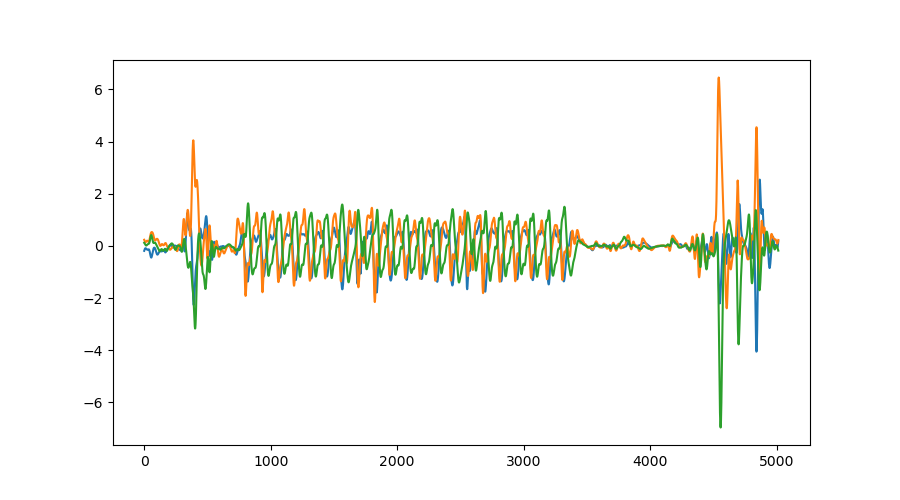

<IPython.core.display.Javascript object>


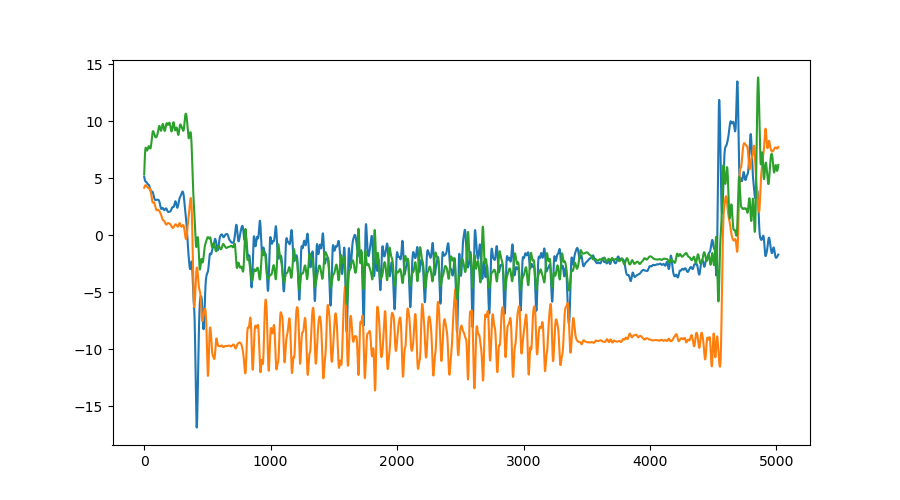

In [662]:
filter_gyr = filter_data(gyr, fs=sampling_frequency, fc=4)
plt.figure(figsize=(9,5))
plt.plot(filter_gyr)

filter_acc = filter_data(acc, fs=sampling_frequency, fc=4)
plt.figure(figsize=(9,5))
plt.plot(filter_acc)

# data_gyr.plot(x = 0, y = [1, 2, 3])
# data_acc.plot(x = 0, y = [1, 2, 3])

<IPython.core.display.Javascript object>


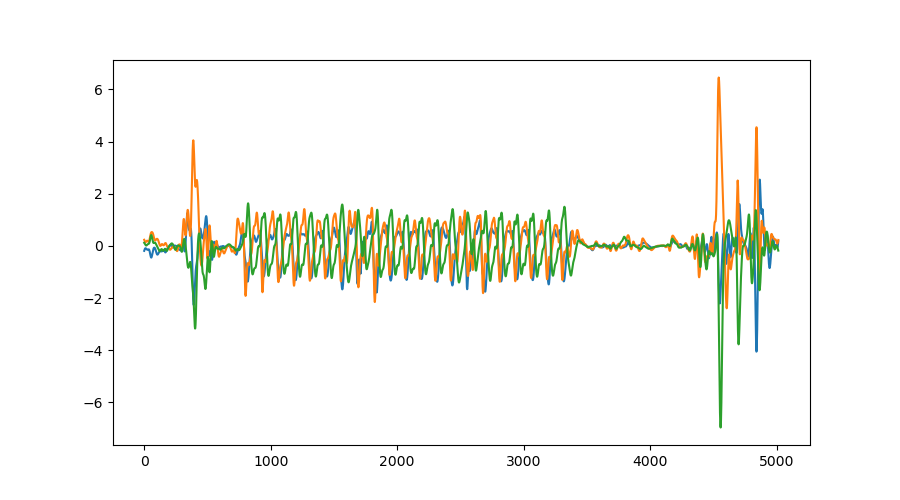

<IPython.core.display.Javascript object>


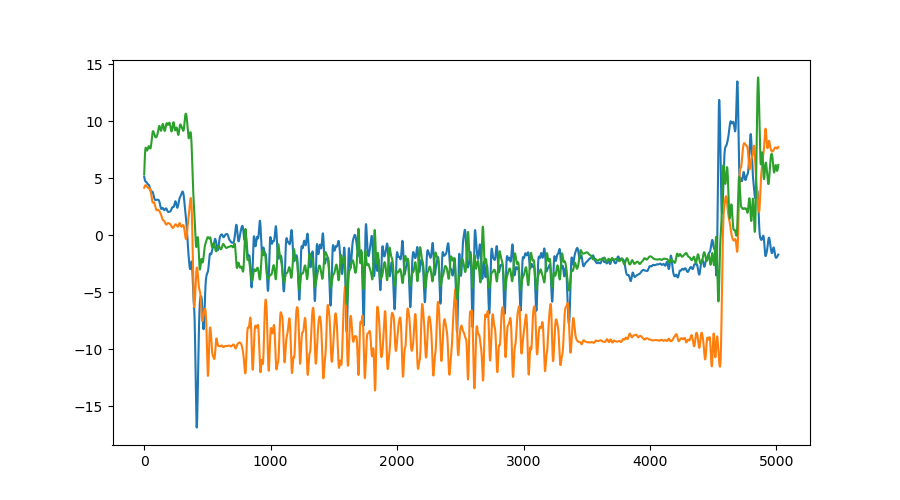

<IPython.core.display.Javascript object>


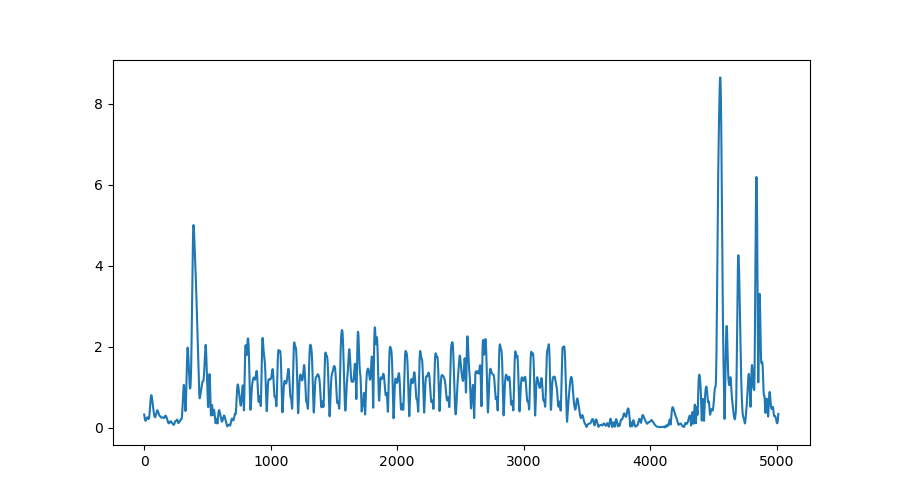

In [664]:
plt.figure(figsize=(9,5))
# plt.plot(gyr[:,0])
plt.plot(filter_gyr)
# plt.plot(filter_gyr[:,0])


plt.figure(figsize=(9,5))
# plt.plot(acc[:,0])
plt.plot(filter_acc)
# plt.plot(filter_acc[:,0])

gyr_abs = np.linalg.norm(filter_gyr,axis=1)
plt.figure(figsize=(9,5))
plt.plot(gyr_abs)
# print(np.mean(gyr_abs))

In [665]:
def cut_data(acc_filt, gyr_filt, freq):

#     SJ: Denny had based his filter on the absolute acceleration. But he mentioned saying that using the angular velocity
#     is better. Changing the code to based it on the angular velocity does result in a better clean up of the unwanted
#     segment at the start and end of the signal
    
    gyr_abs = np.linalg.norm(gyr_filt,axis=1)
#     print(acc_abs)
#     print(np.mean(acc_abs))
#     print(np.mean(gyr_abs))
    peaks, _ = signal.find_peaks(gyr_abs, height=0, distance=freq)
#     print("Peaks")
#     print(peaks)
    diff_peaks = np.diff(peaks)
#     print()
#     print("Difference of Peaks")
#     print(diff_peaks)
    gap1  = np.argmax(diff_peaks[:20])
#     print()
#     print("Gap 1")
#     print(gap1)
    gap2  = np.argmax(diff_peaks[-10:])
#     print()
#     print("Gap 2")
#     print(gap2)
    gap2  = int(gap2 + np.shape(diff_peaks)-10)
#     print()
#     print("Gap 2R")
#     print(gap2)

    
    acc_cut = acc_filt[peaks[gap1+1]:peaks[gap2],:]
    gyr_cut = gyr_filt[peaks[gap1+1]:peaks[gap2],:]
#     gyr_abs_cut = gyr_abs[peaks[gap1+1]:peaks[gap2]]


    gyr_abs = np.linalg.norm(gyr_cut,axis=1)
    peaks, _ = signal.find_peaks(gyr_abs, height=0, distance=freq)
#     print(peaks)
#     print(peaks[0])
    acc_cut = acc_cut[peaks[1]:,:]
    gyr_cut = gyr_cut[peaks[1]:,:]
    
    return acc_cut, gyr_cut

In [666]:
acc_cut, gyr_cut = cut_data(filter_acc, filter_gyr, sampling_frequency)

# To find the next 0 crossing using the gyro data

# zero_crossings = np.where(np.diff(np.signbit(gyr_cut[:,0])))[0]
# print(gyr_cut)
# print(gyr_cut[:,0])
# print(zero_crossings)

<IPython.core.display.Javascript object>


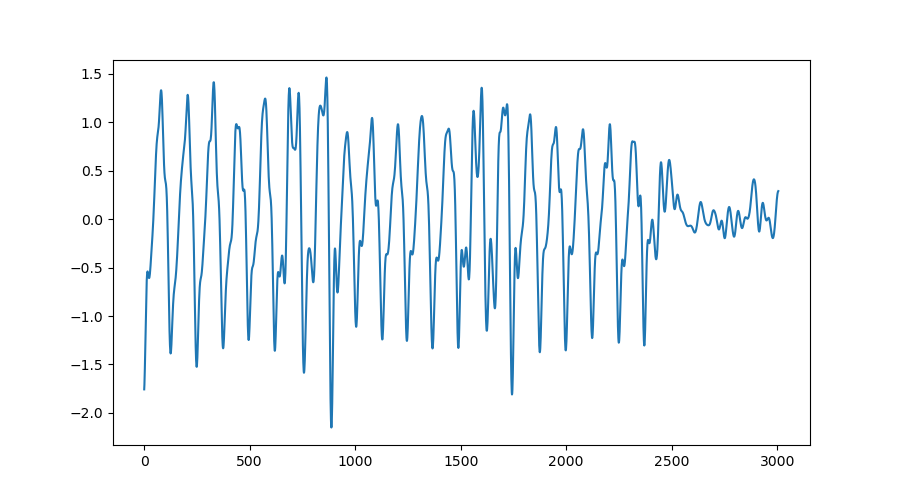

<IPython.core.display.Javascript object>


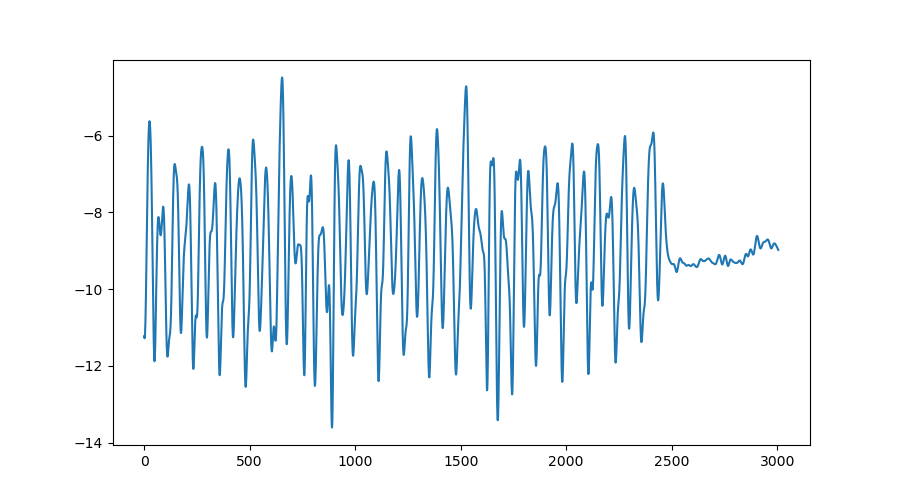

In [686]:
plt.figure(figsize=(9,5))
plt.plot(gyr_cut[:,1])
plt.figure(figsize=(9,5))
plt.plot(acc_cut[:,1])
# plt.figure(figsize=(9,5))
# plt.plot(gyr_abs_cut)

In [698]:
def extract_frame(acc_cut, gyr_cut, samp_freq):
    
#     For 8s as the time frame to be used
    data_point = (samp_freq[0]*8).astype(np.int64)
    gyr_frame = gyr_cut[0: data_point-1,:]
    acc_frame = acc_cut[0: data_point-1,:]
    
    return gyr_frame, acc_frame

In [699]:
acc_cut, gyr_cut = extract_frame(acc_cut, gyr_cut, sampling_frequency)

<IPython.core.display.Javascript object>


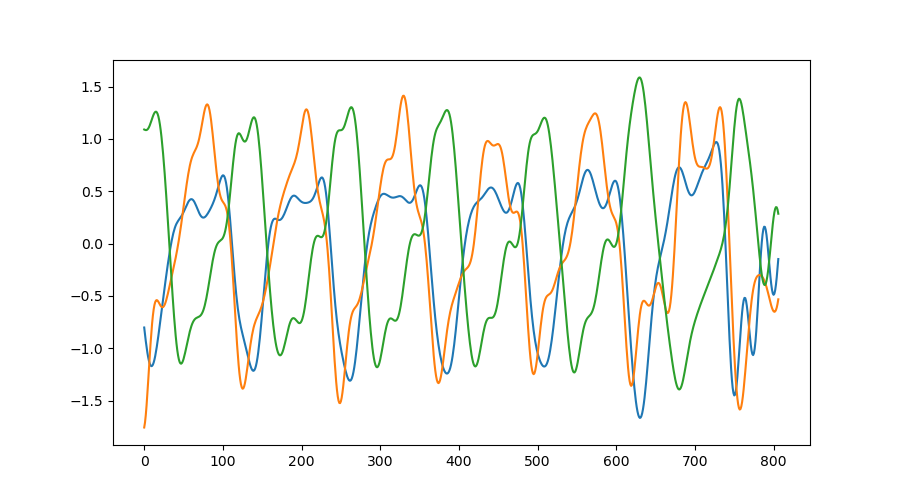

<IPython.core.display.Javascript object>


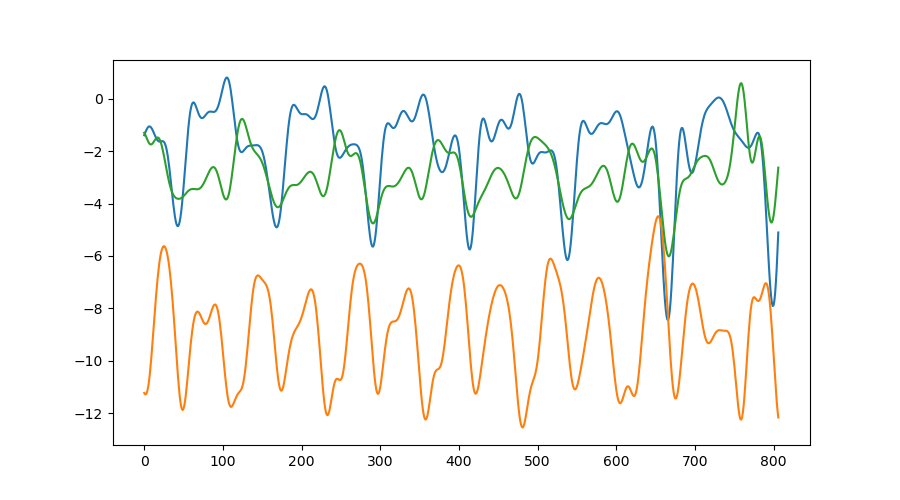

In [695]:
plt.figure(figsize=(9,5))
plt.plot(acc_cut)

plt.figure(figsize=(9,5))
plt.plot(gyr_cut)